In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import biom
import qiime2
from scipy.stats import pearsonr
from qiime2.plugins.feature_table.methods import filter_seqs
from qiime2.plugins.diversity_lib.methods import shannon_entropy, faith_pd
import skbio
from scipy import stats

import warnings

In [2]:
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

In [3]:
%cd /storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed


In [4]:
#read feature table
q2202_s1_ftable_file = 'qiita_2202/data_processing/interpolation_rarefaction/donorA_rarefied_interpolated_feces.csv'
q2202_s2_ftable_file = 'qiita_2202/data_processing/interpolation_rarefaction/donorB_rarefied_interpolated_feces.csv'
q2202_metadata_file = 'qiita_2202/2202_metadata.tsv'

q550_m_ftable_file = 'qiita_550/data_processing/interpolation_rarefaction/male_rarefied_interpolated_feces.csv'
q550_f_ftable_file = 'qiita_550/data_processing/interpolation_rarefaction/female_rarefied_interpolated_feces.csv'
q550_metadata_file = 'qiita_550/raw_data/550_metadata.txt'

In [5]:
#get dataframe only feces and no mislabeled
q2202_s1_df = pd.read_csv(q2202_s1_ftable_file, index_col = [0])
q2202_s2_df = pd.read_csv(q2202_s2_ftable_file, index_col = [0])

q550_m_df = pd.read_csv(q550_m_ftable_file, index_col = [0])
q550_m_df = q550_m_df.sort_index()
q550_f_df = pd.read_csv(q550_f_ftable_file, index_col = [0])
q550_f_df = q550_f_df.sort_index()

#metadata
q550_metadata = pd.read_csv(q550_metadata_file, sep = '\t')

In [28]:
print(q2202_s1_df.shape, q2202_s2_df.shape, q550_m_df.shape, q550_f_df.shape)

(365, 1531) (253, 1545) (443, 1219) (186, 544)


In [10]:
%mkdir alpha_diversity_analysis_4_datasets

In [6]:
%cd alpha_diversity_analysis_4_datasets

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/alpha_diversity_analysis_4_datasets


In [30]:
#biom observations are rows and samples are columns
q2202_s1_df.T.to_csv('q2202_donorA_rarefied_interpolated_feces.tsv', sep = '\t')
q2202_s2_df.T.to_csv('q2202_donorB_rarefied_interpolated_feces.tsv', sep = '\t')

q550_m_df.T.to_csv('q550_male_rarefied_interpolated_feces.tsv', sep = '\t')
q550_f_df.T.to_csv('q550_female_rarefied_interpolated_feces.tsv', sep = '\t')

In [ ]:
#make biom file
biom convert -i q2202_donorA_rarefied_interpolated_feces.tsv -o q2202_donorA_rarefied_interpolated_feces.biom --to-hdf5
biom convert -i q2202_donorB_rarefied_interpolated_feces.tsv -o q2202_donorB_rarefied_interpolated_feces.biom --to-hdf5
biom convert -i q550_male_rarefied_interpolated_feces.tsv -o q550_male_rarefied_interpolated_feces.biom --to-hdf5
biom convert -i q550_female_rarefied_interpolated_feces.tsv -o q550_female_rarefied_interpolated_feces.biom --to-hdf5

In [7]:
#read feature table as qiime2 artifact
q2202_s1_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q2202_donorA_rarefied_interpolated_feces.biom')
q2202_s2_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q2202_donorB_rarefied_interpolated_feces.biom')
q550_m_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q550_male_rarefied_interpolated_feces.biom')
q550_f_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q550_female_rarefied_interpolated_feces.biom')

## assign taxonomy

In [ ]:
#read representative sequences
q2202_res_seqs = qiime2.Artifact.import_data('FeatureData[Sequence]', '2202_rep_seqs.fa')
q550_res_seqs = qiime2.Artifact.import_data('FeatureData[Sequence]', '550_rep_seqs.fa')

In [8]:
#filter rep sequences
q2202_s1_filtered_sequences = filter_seqs(q2202_res_seqs, q2202_s1_feature_table)
q2202_s2_filtered_sequences = filter_seqs(q2202_res_seqs, q2202_s2_feature_table)
q550_m_filtered_sequences = filter_seqs(q550_res_seqs, q550_m_feature_table)
q550_f_filtered_sequences = filter_seqs(q550_res_seqs, q550_f_feature_table)

In [9]:
#save sequences to qza
q2202_s1_filtered_sequences.filtered_data.save('q2202_s1_filtered_sequences.qza')
q2202_s2_filtered_sequences.filtered_data.save('q2202_s2_filtered_sequences.qza')

q550_m_filtered_sequences.filtered_data.save('q550_m_filtered_sequences.qza')
q550_f_filtered_sequences.filtered_data.save('q550_f_filtered_sequences.qza')

'q550_f_filtered_sequences.qza'

In [12]:
%mkdir q2202_s1_phylogeny
%mkdir q2202_s2_phylogeny
%mkdir q550_m_phylogeny
%mkdir q550_f_phylogeny

In [ ]:
#make phylogenetic tree for each subject
qiime phylogeny align-to-tree-mafft-fasttree \
--i-sequences q2202_s1_filtered_sequences.qza \
--o-alignment q2202_s1_phylogeny/aligned-rep-seqs.qza \
--o-masked-alignment q2202_s1_phylogeny/masked-aligned-rep-seqs.qza \
--o-tree q2202_s1_phylogeny/unrooted-tree.qza \
--o-rooted-tree q2202_s1_phylogeny/rooted-tree.qza

qiime phylogeny align-to-tree-mafft-fasttree \
--i-sequences q2202_s2_filtered_sequences.qza \
--o-alignment q2202_s2_phylogeny/aligned-rep-seqs.qza \
--o-masked-alignment q2202_s2_phylogeny/masked-aligned-rep-seqs.qza \
--o-tree q2202_s2_phylogeny/unrooted-tree.qza \
--o-rooted-tree q2202_s2_phylogeny/rooted-tree.qza

qiime phylogeny align-to-tree-mafft-fasttree \
--i-sequences q550_m_filtered_sequences.qza \
--o-alignment q550_m_phylogeny/aligned-rep-seqs.qza \
--o-masked-alignment q550_m_phylogeny/masked-aligned-rep-seqs.qza \
--o-tree q550_m_phylogeny/unrooted-tree.qza \
--o-rooted-tree q550_m_phylogeny/rooted-tree.qza

qiime phylogeny align-to-tree-mafft-fasttree \
--i-sequences q550_f_filtered_sequences.qza \
--o-alignment q550_f_phylogeny/aligned-rep-seqs.qza \
--o-masked-alignment q550_f_phylogeny/masked-aligned-rep-seqs.qza \
--o-tree q550_f_phylogeny/unrooted-tree.qza \
--o-rooted-tree q550_f_phylogeny/rooted-tree.qza

## correlation between time and alpha diversity

In [14]:
def export_alpha_diversity_to_pandas(artifact):
    #change qiime 2 artifact to dataframe
    df = artifact.vector.view(qiime2.Metadata).to_dataframe()
    return df

def plot_alpha_div_time_correlation(alpha_diversity_artifact, metric, title):
    
    alpha_diversity_df = export_alpha_diversity_to_pandas(alpha_diversity_artifact)

    #calculate pearson's correlation between alpha diversity and time
    rho, pvalue = pearsonr(alpha_diversity_df.index.astype(int), alpha_diversity_df[metric])
    
    #plot
    plt.figure(figsize = [12, 2])
    sns.lineplot(data = alpha_diversity_df,
                 x = alpha_diversity_df.index,
                 y = metric,
                 linewidth = .5,
                 color = 'Black'
                )
    sns.scatterplot(data = alpha_diversity_df,
                    x = alpha_diversity_df.index,
                    y = metric,
                    s = 15,
                    color = 'Black'
                   )

    plt.title('rho: {}, pvalue = {}'.format(round(rho, 3), round(pvalue, 2)), fontsize = 12)
    x_ticks = [i for i in range(0, len(alpha_diversity_df.index), 10)]
    plt.xticks(x_ticks, fontsize = 6)
    plt.savefig('{}.png'.format(title))
    plt.show()

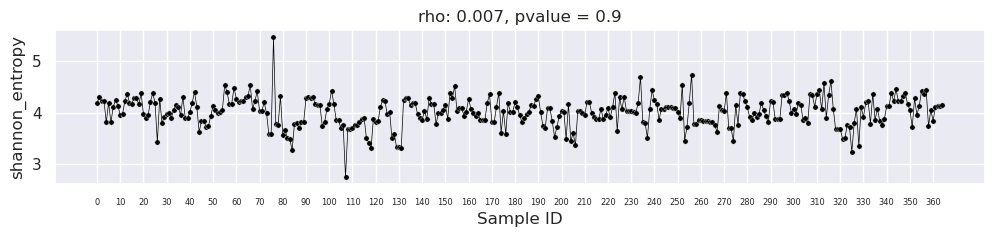

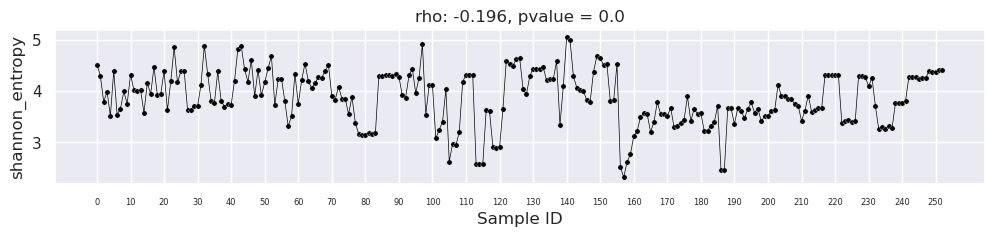

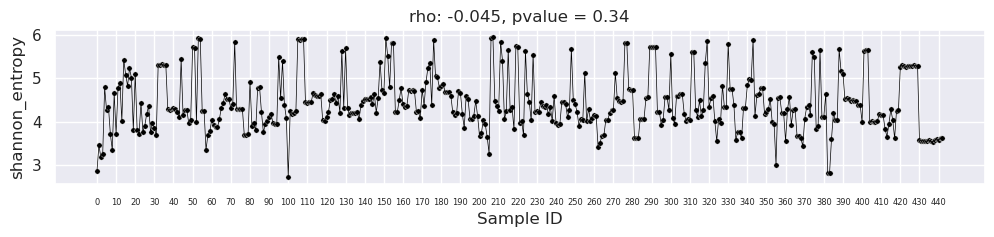

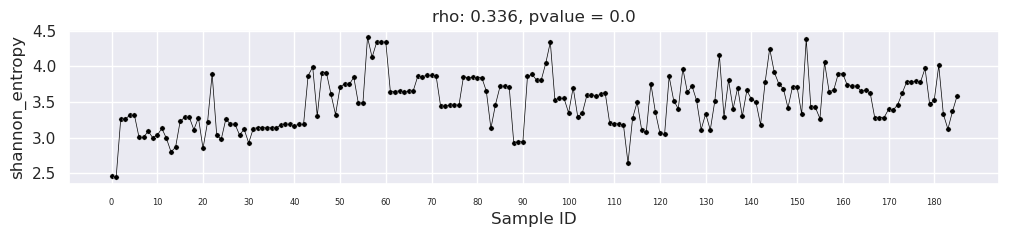

In [56]:
#calculate shannon diversity
q2202_s1_shannon_diversity = shannon_entropy(q2202_s1_feature_table)
q2202_s2_shannon_diversity = shannon_entropy(q2202_s2_feature_table)
q550_m_shannon_diversity = shannon_entropy(q550_m_feature_table)
q550_f_shannon_diversity = shannon_entropy(q550_f_feature_table)

#plot correlation with time
plot_alpha_div_time_correlation(q2202_s1_shannon_diversity, 'shannon_entropy', 'q2202_s1')
plot_alpha_div_time_correlation(q2202_s2_shannon_diversity, 'shannon_entropy', 'q2202_s2')

plot_alpha_div_time_correlation(q550_m_shannon_diversity, 'shannon_entropy', 'q550_m')
plot_alpha_div_time_correlation(q550_f_shannon_diversity, 'shannon_entropy', 'q550_f')

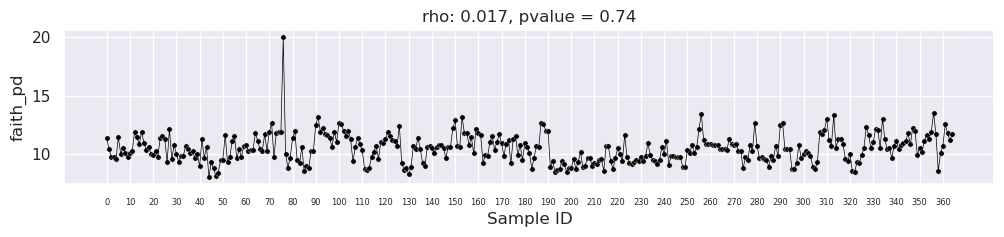

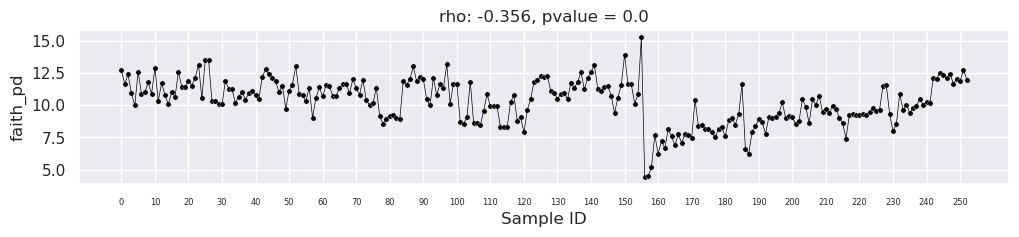

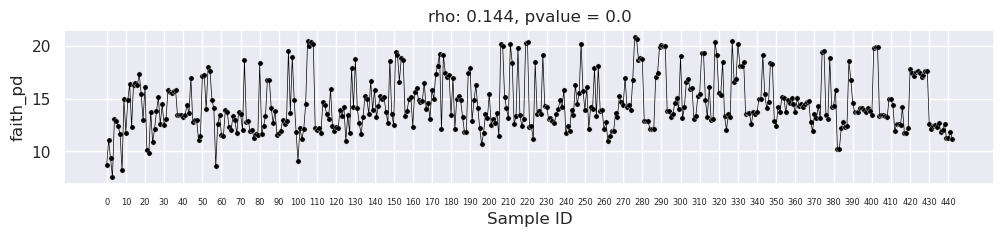

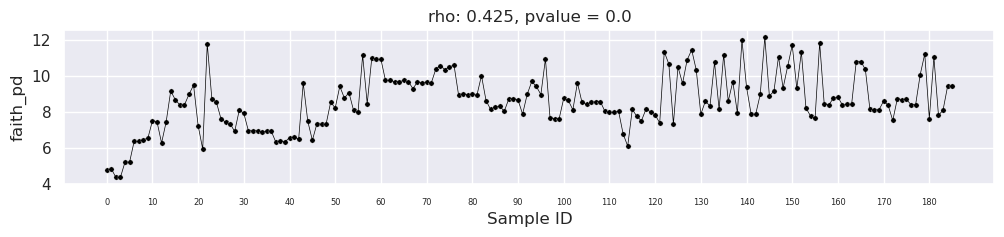

In [16]:
# Faith's phylogenetic index
q2202_s1_tree = qiime2.Artifact.load('q2202_s1_phylogeny/rooted-tree.qza')
q2202_s2_tree = qiime2.Artifact.load('q2202_s2_phylogeny/rooted-tree.qza')
q550_m_tree = qiime2.Artifact.load('q550_m_phylogeny/rooted-tree.qza')
q550_f_tree = qiime2.Artifact.load('q550_f_phylogeny/rooted-tree.qza')
#calculate index
q2202_s1_faith_pd = faith_pd(q2202_s1_feature_table, q2202_s1_tree)
q2202_s2_faith_pd = faith_pd(q2202_s2_feature_table, q2202_s2_tree)
q550_m_faith_pd = faith_pd(q550_m_feature_table, q550_m_tree)
q550_f_faith_pd = faith_pd(q550_f_feature_table, q550_f_tree)

#plot correlation with time
plot_alpha_div_time_correlation(q2202_s1_faith_pd, 'faith_pd', 'q2202_s1')
plot_alpha_div_time_correlation(q2202_s2_faith_pd, 'faith_pd', 'q2202_s2')

plot_alpha_div_time_correlation(q550_m_faith_pd, 'faith_pd', 'q550_m')
plot_alpha_div_time_correlation(q550_f_faith_pd, 'faith_pd', 'q550_m')

## alpha diversity difference between subjects - t test

In [18]:
q2202_s1_faith_pd_df = export_alpha_diversity_to_pandas(q2202_s1_faith_pd)
q2202_s2_faith_pd_df = export_alpha_diversity_to_pandas(q2202_s2_faith_pd)
q550_m_faith_pd_df = export_alpha_diversity_to_pandas(q550_m_faith_pd)
q550_f_faith_pd_df = export_alpha_diversity_to_pandas(q550_f_faith_pd)

In [19]:
fvalue, pvalue = stats.f_oneway(q2202_s1_faith_pd_df['faith_pd'], q2202_s2_faith_pd_df['faith_pd'], q550_m_faith_pd_df['faith_pd'], q550_f_faith_pd_df['faith_pd'])
print(fvalue, pvalue)

571.4744329751686 2.357029060530468e-233


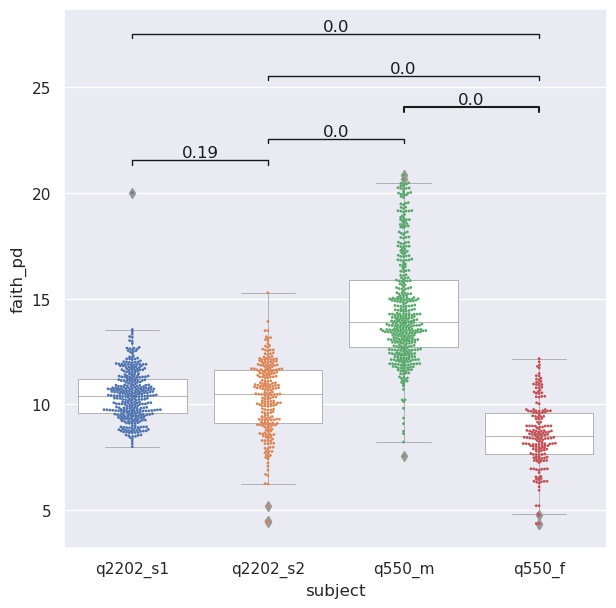

In [65]:
t1, p1 = stats.ttest_ind(q2202_s1_faith_pd_df['faith_pd'], q2202_s2_faith_pd_df['faith_pd'])
t2, p2 = stats.ttest_ind(q2202_s1_faith_pd_df['faith_pd'], q550_m_faith_pd_df['faith_pd'])
t3, p3 = stats.ttest_ind(q2202_s1_faith_pd_df['faith_pd'], q550_f_faith_pd_df['faith_pd'])

t4, p4 = stats.ttest_ind(q2202_s2_faith_pd_df['faith_pd'], q550_m_faith_pd_df['faith_pd'])
t5, p5 = stats.ttest_ind(q2202_s2_faith_pd_df['faith_pd'], q550_f_faith_pd_df['faith_pd'])

t6, p6 = stats.ttest_ind(q550_m_faith_pd_df['faith_pd'], q550_f_faith_pd_df['faith_pd'])


q2202_s1_faith_pd_df['subject'] = 'q2202_s1'
q2202_s2_faith_pd_df['subject'] = 'q2202_s2'
q550_m_faith_pd_df['subject'] = 'q550_m'
q550_f_faith_pd_df['subject'] = 'q550_f'

faith_df = q2202_s1_faith_pd_df.append(q2202_s2_faith_pd_df).append(q550_m_faith_pd_df).append(q550_f_faith_pd_df)

plt.figure(figsize = [7, 7])
sns.boxplot(data = faith_df, y = 'faith_pd', x = 'subject', color = 'White', linewidth=.5)
sns.swarmplot(data = faith_df, y = 'faith_pd', x = 'subject', s = 2)

x1, x2 = 2, 3
y, h, col = faith_df['faith_pd'].max() + 3, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, round(p6, 2), ha='center', va='bottom', color=col)

x1, x2 = 0, 1
y, h, col = faith_df['faith_pd'].max() + .5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p1, 2), ha='center', va='bottom', color=col)

x1, x2 = 1, 2
y, h, col = faith_df['faith_pd'].max() + 1.5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p4, 2), ha='center', va='bottom', color=col)

x1, x2 = 1, 3
y, h, col = faith_df['faith_pd'].max() + 4.5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p2, 2), ha='center', va='bottom', color=col)


x1, x2 = 0, 3
y, h, col = faith_df['faith_pd'].max() + 6.5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p3, 2), ha='center', va='bottom', color=col)

plt.savefig('pairwise_ttest_faith_pd.png')
plt.show()

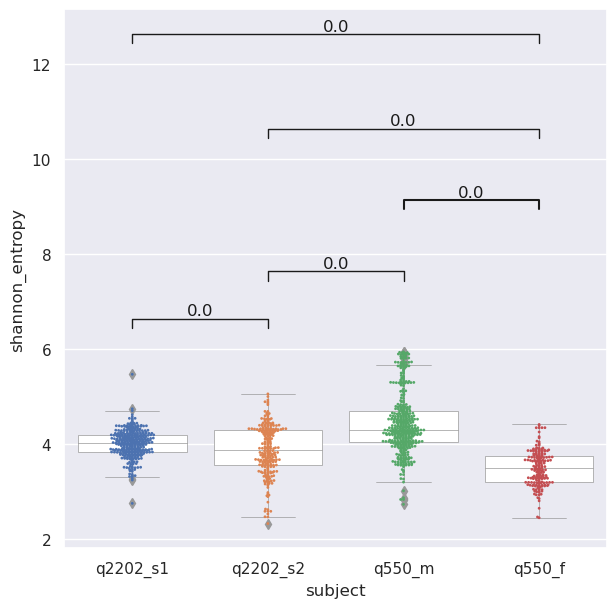

In [64]:
q2202_s1_shannon_df = export_alpha_diversity_to_pandas(q2202_s1_shannon_diversity)
q2202_s2_shannon_df = export_alpha_diversity_to_pandas(q2202_s2_shannon_diversity)
q550_m_shannon_df = export_alpha_diversity_to_pandas(q550_m_shannon_diversity)
q550_f_shannon_df = export_alpha_diversity_to_pandas(q550_f_shannon_diversity)


t1, p1 = stats.ttest_ind(q2202_s1_shannon_df['shannon_entropy'], q2202_s2_shannon_df['shannon_entropy'])
t2, p2 = stats.ttest_ind(q2202_s1_shannon_df['shannon_entropy'], q550_m_shannon_df['shannon_entropy'])
t3, p3 = stats.ttest_ind(q2202_s1_shannon_df['shannon_entropy'], q550_f_shannon_df['shannon_entropy'])

t4, p4 = stats.ttest_ind(q2202_s2_shannon_df['shannon_entropy'], q550_m_shannon_df['shannon_entropy'])
t5, p5 = stats.ttest_ind(q2202_s2_shannon_df['shannon_entropy'], q550_f_shannon_df['shannon_entropy'])

t6, p6 = stats.ttest_ind(q550_m_shannon_df['shannon_entropy'], q550_f_shannon_df['shannon_entropy'])


q2202_s1_shannon_df['subject'] = 'q2202_s1'
q2202_s2_shannon_df['subject'] = 'q2202_s2'
q550_m_shannon_df['subject'] = 'q550_m'
q550_f_shannon_df['subject'] = 'q550_f'

shannon_df = q2202_s1_shannon_df.append(q2202_s2_shannon_df).append(q550_m_shannon_df).append(q550_f_shannon_df)

plt.figure(figsize = [7, 7])
sns.boxplot(data = shannon_df, y = 'shannon_entropy', x = 'subject', color = 'White', linewidth = .5)
sns.swarmplot(data = shannon_df, y = 'shannon_entropy', x = 'subject', s = 2)

x1, x2 = 2, 3
y, h, col = shannon_df['shannon_entropy'].max() + 3, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, round(p6, 2), ha='center', va='bottom', color=col)

x1, x2 = 0, 1
y, h, col = shannon_df['shannon_entropy'].max() + .5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p1, 2), ha='center', va='bottom', color=col)

x1, x2 = 1, 2
y, h, col = shannon_df['shannon_entropy'].max() + 1.5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p4, 2), ha='center', va='bottom', color=col)

x1, x2 = 1, 3
y, h, col = shannon_df['shannon_entropy'].max() + 4.5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p2, 2), ha='center', va='bottom', color=col)


x1, x2 = 0, 3
y, h, col = shannon_df['shannon_entropy'].max() + 6.5, .2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, round(p3, 2), ha='center', va='bottom', color=col)

plt.savefig('pairwise_ttest_shannon_entropy.png')
plt.show()